In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data
df = pd.read_csv('processed_data_full.csv')
X = df.drop(['High_Demand', 'Date'], axis=1)
y = df['High_Demand']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"    Class {cls}: {cnt} ({cnt/len(y_train):.2%})")
    
    
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


    Class 0: 5237 (74.94%)
    Class 1: 1751 (25.06%)


In [71]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Logistic Regression

# Stage 1 hyperparameter tuning with Grid Search
param_grid = {'C': [0.1, 1, 5, 10, 15],
              'penalty': ['l1', 'l2'],
              'max_iter': [1000],
              'class_weight': [None, 'balanced']
              }

lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1, return_train_score=True)
grid_lr.fit(X_train_scaled, y_train)

lr_model = grid_lr.best_estimator_
print(f"Best params: {grid_lr.best_params_}")
print(f"Best CV F1-score: {grid_lr.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
Best CV F1-score: 0.8532


In [72]:
# Stage 2 hyperparameter tuning (more granular)
param_grid_2 = {'C': np.linspace(5, 15, 9),
              'penalty': ['l2'],
              'max_iter': [1000],
              'class_weight': [None, 'balanced']
              }
lr2 = LogisticRegression(random_state=42)
grid_round2_lr = GridSearchCV(lr, param_grid_2, cv=tscv, scoring='f1', n_jobs=-1, verbose=1, return_train_score=True)
grid_round2_lr.fit(X_train_scaled, y_train)
lr_model_2 = grid_round2_lr.best_estimator_
print(f"Best params: {grid_round2_lr.best_params_}")
print(f"Best CV F1-score: {grid_round2_lr.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 10.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
Best CV F1-score: 0.8532


In [73]:
# Model evaluation on test set
y_pred = lr_model_2.predict(X_test_scaled)
y_proba = lr_model_2.predict_proba(X_test_scaled)[:, 1]

metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
}

cm = confusion_matrix(y_test, y_pred)

metrics_df = pd.DataFrame([metrics])
print(metrics_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.919908   0.777365 0.954442  0.856851 0.978486


In [74]:
# Error Analysis
df_test_with_date = pd.read_csv('processed_data_full.csv')
df_test_with_date['Date'] = pd.to_datetime(df_test_with_date['Date'])
df_test_with_date['year_month'] = df_test_with_date['Date'].dt.to_period('M')

# Filter to test months
unique_months = sorted(df_test_with_date['year_month'].unique())
test_months = unique_months[10:]
test_mask = df_test_with_date['year_month'].isin(test_months)

df_test_temporal = df_test_with_date[test_mask][['Date', 'Hour', 'High_Demand']].reset_index(drop=True)
if len(df_test_temporal) != len(y_test):
    min_len = min(len(df_test_temporal), len(y_test))
    df_test_temporal = df_test_temporal.iloc[:min_len]
    df_test_temporal['y_pred'] = y_pred[:min_len]
    df_test_temporal['y_true'] = y_test.values[:min_len]
else:
    # Lengths match - proceed normally
    df_test_temporal['y_pred'] = y_pred
    df_test_temporal['y_true'] = y_test.values
    
df_test_temporal['error'] = (df_test_temporal['y_pred'] != df_test_temporal['y_true']).astype(int)

df_test_temporal['error_type'] = 'Correct'
df_test_temporal.loc[(df_test_temporal['y_true'] == 0) & 
                     (df_test_temporal['y_pred'] == 1), 'error_type'] = 'False Positive'
df_test_temporal.loc[(df_test_temporal['y_true'] == 1) & 
                     (df_test_temporal['y_pred'] == 0), 'error_type'] = 'False Negative'

error_by_hour = df_test_temporal.groupby('Hour').agg({
'error': ['sum', 'count', 'mean']
}).reset_index()

error_by_hour.columns = ['Hour', 'Errors', 'Total', 'Error_Rate']
error_by_hour = error_by_hour.sort_values('Error_Rate', ascending=False)

print("\nTop 10 Hours with Highest Error Rates:")
print(error_by_hour.head(10).to_string(index=False))

print("\nTop 10 Hours with Lowest Error Rates:")
print(error_by_hour.tail(10).to_string(index=False))

print("Error Type Breakdown:")
print(df_test_temporal['error_type'].value_counts())


Top 10 Hours with Highest Error Rates:
 Hour  Errors  Total  Error_Rate
   12       8     61    0.131148
   21       8     61    0.131148
   19       8     61    0.131148
   17       8     61    0.131148
    6       8     61    0.131148
   16       7     61    0.114754
   20       7     61    0.114754
   23       7     61    0.114754
   14       6     61    0.098361
   15       6     61    0.098361

Top 10 Hours with Lowest Error Rates:
 Hour  Errors  Total  Error_Rate
    0       4     61    0.065574
    8       3     61    0.049180
    9       3     61    0.049180
   11       3     61    0.049180
    5       3     61    0.049180
    2       3     61    0.049180
   22       3     61    0.049180
    1       2     61    0.032787
   10       1     61    0.016393
   13       1     61    0.016393
Error Type Breakdown:
error_type
Correct           1343
False Positive     104
False Negative      17
Name: count, dtype: int64


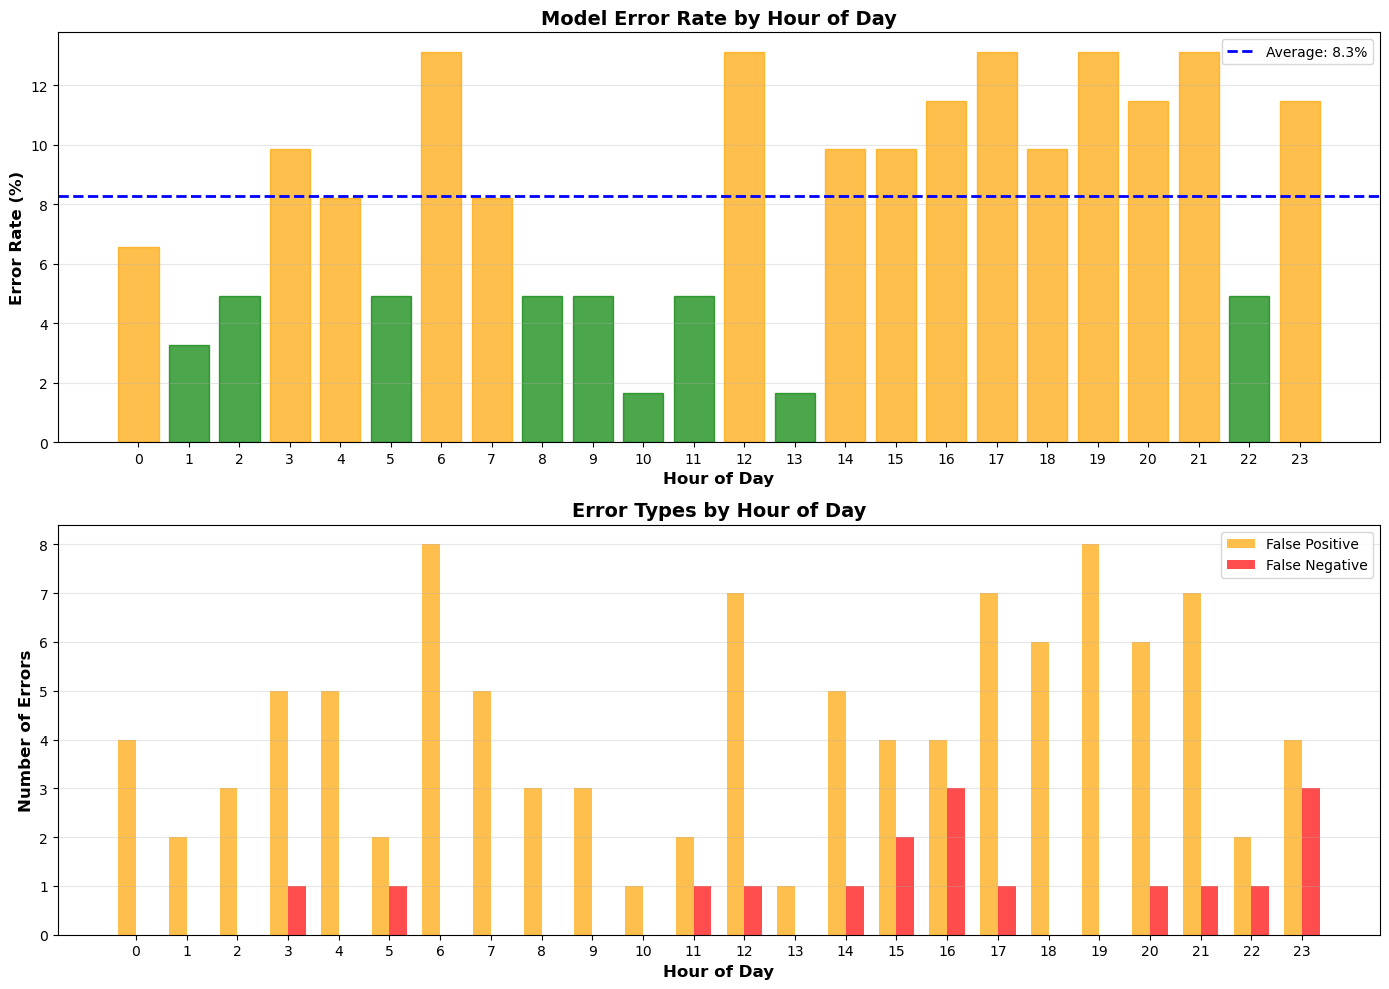

In [75]:
# Error visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Error rate by hour
ax1 = axes[0]
error_by_hour_sorted = error_by_hour.sort_values('Hour')

bars = ax1.bar(error_by_hour_sorted['Hour'], 
               error_by_hour_sorted['Error_Rate'] * 100,
               edgecolor='black', alpha=0.7)

# Color bars by error rate
for i, (_, row) in enumerate(error_by_hour_sorted.iterrows()):
    if row['Error_Rate'] < 0.05:
        bars[i].set_color('green')
    elif row['Error_Rate'] < 0.15:
        bars[i].set_color('orange')
    else:
        bars[i].set_color('red')

# Add average line
avg_error = error_by_hour['Error_Rate'].mean()
ax1.axhline(y=avg_error * 100, color='blue', linestyle='--', 
            linewidth=2, label=f'Average: {avg_error*100:.1f}%')

ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Error Rate by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24))
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Error types by hour
ax2 = axes[1]
error_types_by_hour = df_test_temporal.groupby(['Hour', 'error_type']).size().unstack(fill_value=0)

x = np.arange(24)
width = 0.35

if 'False Positive' in error_types_by_hour.columns:
    fp_counts = [error_types_by_hour.loc[h, 'False Positive'] if h in error_types_by_hour.index else 0 
                 for h in range(24)]
    ax2.bar(x - width/2, fp_counts, width, 
            label='False Positive', color='orange', alpha=0.7)

if 'False Negative' in error_types_by_hour.columns:
    fn_counts = [error_types_by_hour.loc[h, 'False Negative'] if h in error_types_by_hour.index else 0 
                 for h in range(24)]
    ax2.bar(x + width/2, fn_counts, width, 
            label='False Negative', color='red', alpha=0.7)

ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
ax2.set_title('Error Types by Hour of Day', fontsize=14, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
#plt.savefig('error_analysis_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()


In [76]:
if 'Seasons' in df_test_with_date.columns:
    # Seasons exists as categorical
    df_test_seasonal = df_test_with_date[test_mask][['Date', 'Hour', 'Seasons', 'High_Demand']].reset_index(drop=True)
    season_col = 'Seasons'
else:
    # Seasons is one-hot encoded - reconstruct it
    season_cols = [col for col in df_test_with_date.columns if 'Seasons_' in col or 'Season' in col]
    print(f"\nFound encoded season columns: {season_cols}")
    
    df_test_seasonal = df_test_with_date[test_mask][['Date', 'Hour', 'High_Demand'] + season_cols].reset_index(drop=True)
    
    # Reconstruct season from one-hot encoding
    def get_season(row):
        if 'Seasons_Spring' in season_cols and row.get('Seasons_Spring', 0) == 1:
            return 'Spring'
        elif 'Seasons_Summer' in season_cols and row.get('Seasons_Summer', 0) == 1:
            return 'Summer'
        elif 'Seasons_Winter' in season_cols and row.get('Seasons_Winter', 0) == 1:
            return 'Winter'
        else:
            return 'Autumn'  # Base category when drop_first=True
    
    df_test_seasonal['Seasons'] = df_test_seasonal.apply(get_season, axis=1)
    season_col = 'Seasons'

# Handle length mismatch
if len(df_test_seasonal) != len(y_test):
    print(f"\n⚠ Length mismatch: {len(df_test_seasonal)} vs {len(y_test)}")
    min_len = min(len(df_test_seasonal), len(y_test))
    df_test_seasonal = df_test_seasonal.iloc[:min_len]
    df_test_seasonal['y_pred'] = y_pred[:min_len]
    df_test_seasonal['y_true'] = y_test.values[:min_len]
else:
    print(f"\n✓ Lengths match: {len(df_test_seasonal)}")
    df_test_seasonal['y_pred'] = y_pred
    df_test_seasonal['y_true'] = y_test.values

# Calculate errors
df_test_seasonal['error'] = (df_test_seasonal['y_pred'] != df_test_seasonal['y_true']).astype(int)
df_test_seasonal['error_type'] = 'Correct'
df_test_seasonal.loc[(df_test_seasonal['y_true'] == 0) & 
                     (df_test_seasonal['y_pred'] == 1), 'error_type'] = 'False Positive'
df_test_seasonal.loc[(df_test_seasonal['y_true'] == 1) & 
                     (df_test_seasonal['y_pred'] == 0), 'error_type'] = 'False Negative'

print(f"\n✓ Seasonal error analysis dataframe created")
print(f"  Seasons in test set: {df_test_seasonal[season_col].unique()}")


Found encoded season columns: ['Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']

⚠ Length mismatch: 1464 vs 1748

✓ Seasonal error analysis dataframe created
  Seasons in test set: ['Autumn']


In [77]:
error_by_season_hour = df_test_seasonal.groupby([season_col, 'Hour']).agg({
    'error': ['sum', 'count', 'mean']
}).reset_index()
error_by_season_hour.columns = ['Season', 'Hour', 'Errors', 'Total', 'Error_Rate']

# Find worst hours per season
print("\nWorst 3 Hours Per Season:")
for season in df_test_seasonal[season_col].unique():
    season_data = error_by_season_hour[error_by_season_hour['Season'] == season]
    worst_3 = season_data.nlargest(3, 'Error_Rate')
    print(f"\n{season}:")
    for _, row in worst_3.iterrows():
        print(f"  {int(row['Hour']):02d}:00 - {row['Error_Rate']*100:5.2f}% ({int(row['Errors'])}/{int(row['Total'])})")



Worst 3 Hours Per Season:

Autumn:
  06:00 - 13.11% (8/61)
  12:00 - 13.11% (8/61)
  17:00 - 13.11% (8/61)


In [98]:
# Load full data again
df_full = pd.read_csv('processed_data_full.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full['year_month'] = df_full['Date'].dt.to_period('M')

# Get train months (first 10 months)
unique_months = sorted(df_full['year_month'].unique())
train_months = unique_months[:10]
train_mask = df_full['year_month'].isin(train_months)

# Reconstruct seasons for training set
season_cols = [col for col in df_test_seasonal.columns if 'Seasons_' in col]

def get_season(row):
    if row.get('Seasons_Spring', 0) == 1:
        return 'Spring'
    elif row.get('Seasons_Summer', 0) == 1:
        return 'Summer'
    elif row.get('Seasons_Winter', 0) == 1:
        return 'Winter'
    else:
        return 'Autumn'

df_train = df_test_seasonal[train_mask].copy()
df_train['Season'] = df_train.apply(get_season, axis=1)

print(f"\nTraining Period: December 2017 - September 2018")
print(f"Training Samples: {len(df_train)}")

print("\nSeasonal Distribution in TRAINING Set:")
season_dist_train = df_train['Season'].value_counts()
print(season_dist_train)
print("\nProportions:")
print((season_dist_train / season_dist_train.sum() * 100).round(1))

print("\nSeasonal Distribution in TEST Set:")
print("Autumn: 100%")
print("No other seasons represented in test set!")



Training Period: December 2017 - September 2018
Training Samples: 1464

Seasonal Distribution in TRAINING Set:
Season
Autumn    1464
Name: count, dtype: int64

Proportions:
Season
Autumn    100.0
Name: count, dtype: float64

Seasonal Distribution in TEST Set:
Autumn: 100%
No other seasons represented in test set!


In [104]:
# Verify performance by season

# Get training data only
unique_months = sorted(df_full['year_month'].unique())
train_months = unique_months[:10]
train_mask = df_full['year_month'].isin(train_months)
df_train = df_full[train_mask]

# Prepare features
X_train_full = df_train.drop(['Date', 'High_Demand', 'year_month', 'Season'] + [col for col in df_train.columns if 'Seasons_' in col or 'Rented' in col], axis=1, errors='ignore')

# One-hot encode any remaining categoricals
categorical = X_train_full.select_dtypes(include=['object']).columns.tolist()
if categorical:
    X_train_full = pd.get_dummies(X_train_full, columns=categorical, drop_first=True)

y_train_full = df_train['High_Demand']

print(f"\nTraining data: {X_train_full.shape}")
print(f"Seasons in training: {df_train['Season'].value_counts().to_dict()}")

# Scale features (for logistic regression)
X_train_scaled = scaler.fit_transform(X_train_full)


Training data: (7272, 21)
Seasons in training: {'Spring': 2208, 'Summer': 2208, 'Winter': 2136, 'Autumn': 720}


In [105]:
# Analyze each season's learnability
seasonal_cv_results = {}

for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    season_mask = df_train['Season'] == season
    X_season = X_train_scaled[season_mask]
    y_season = y_train_full[season_mask]
    
    if len(X_season) > 100: 
        print(f"\n{season}:")
        print(f"  Samples: {len(X_season)}")
        print(f"  High-demand: {(y_season==1).sum()} ({(y_season==1).mean()*100:.1f}%)")
        
        # Check class distribution
        class_counts = y_season.value_counts()
        print(f"  Class 0: {class_counts.get(0, 0)}, Class 1: {class_counts.get(1, 0)}")
        
        # Only proceed if both classes present and sufficient samples per class
        if len(class_counts) == 2 and class_counts.min() >= 10:
            try:
                
                # Use StratifiedKFold to ensure both classes in each fold
                # Reduce folds if needed for small seasons
                n_folds = min(3, class_counts.min() // 3)  # At least 3 samples per class per fold
                
                if n_folds >= 2:
                    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
                    cv_scores = cross_val_score(lr_model_2, X_season, y_season, cv=skf, scoring='f1')
                    
                    seasonal_cv_results[season] = {
                        'mean_f1': cv_scores.mean(),
                        'std_f1': cv_scores.std(),
                        'samples': len(X_season),
                        'high_demand_pct': (y_season==1).mean() * 100,
                        'n_folds': n_folds
                    }
                    
                    print(f"  CV F1-score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}) [{n_folds} folds]")
                    print(f"  Individual folds: {[f'{s:.4f}' for s in cv_scores]}")
                else:
                    print(f"  ⚠ Too few samples for reliable CV (skipping)")
                    
            except Exception as e:
                print(f"  Error during CV: {e}")
        else:
            print(f"  Insufficient class balance for CV (skipping)")



Spring:
  Samples: 2208
  High-demand: 592 (26.8%)
  Class 0: 1616, Class 1: 592
  CV F1-score: 0.8437 (±0.0099) [3 folds]
  Individual folds: ['0.8369', '0.8578', '0.8365']

Summer:
  Samples: 2208
  High-demand: 894 (40.5%)
  Class 0: 1314, Class 1: 894
  CV F1-score: 0.8720 (±0.0001) [3 folds]
  Individual folds: ['0.8719', '0.8719', '0.8721']

Autumn:
  Samples: 720
  High-demand: 297 (41.2%)
  Class 0: 423, Class 1: 297
  CV F1-score: 0.8926 (±0.0158) [3 folds]
  Individual folds: ['0.8976', '0.8713', '0.9091']

Winter:
  Samples: 2136
  High-demand: 0 (0.0%)
  Class 0: 2136, Class 1: 0
  Insufficient class balance for CV (skipping)


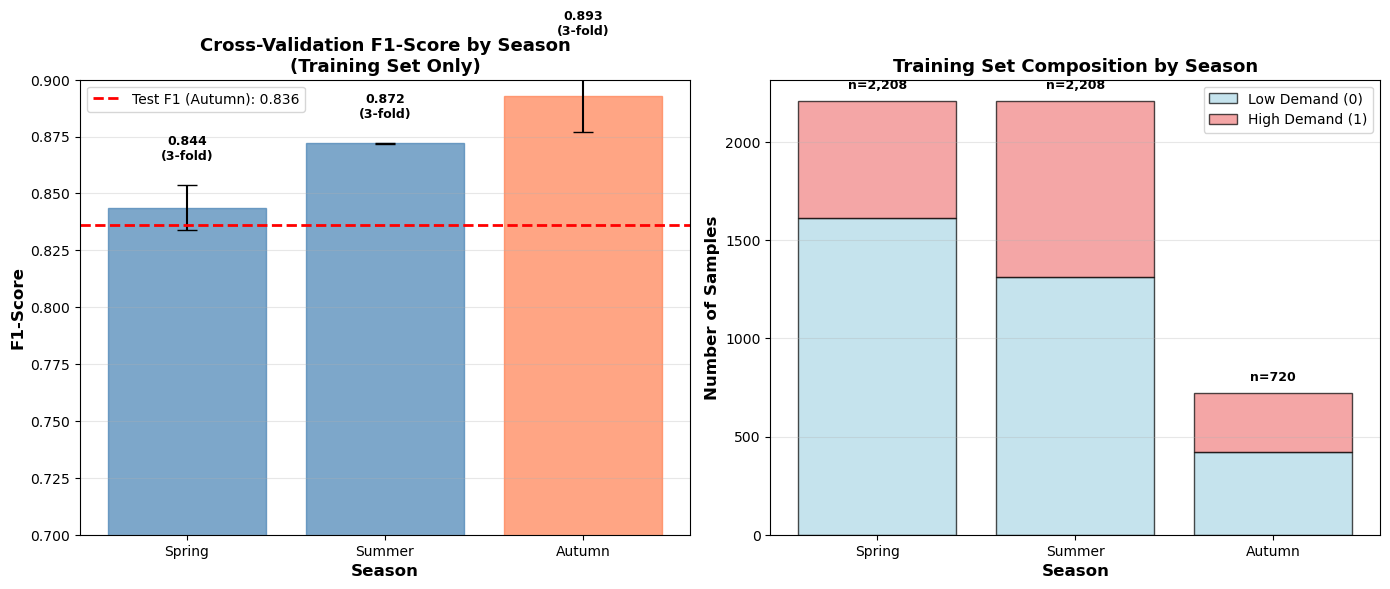

In [106]:
# Visualize learnability by season
if not seasonal_cv_results:
    print("\n⚠ No seasons had sufficient data for CV analysis")
    print("This suggests the training set may be too small or imbalanced per season")
else:
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: CV F1-scores by season
    ax1 = axes[0]
    seasons = list(seasonal_cv_results.keys())
    f1_means = [seasonal_cv_results[s]['mean_f1'] for s in seasons]
    f1_stds = [seasonal_cv_results[s]['std_f1'] for s in seasons]
    
    bars = ax1.bar(seasons, f1_means, yerr=f1_stds, capsize=7,
                   edgecolor='black', alpha=0.7)
    
    # Color Autumn differently (test season)
    colors = []
    for s in seasons:
        if s == 'Autumn':
            colors.append('coral')
        else:
            colors.append('steelblue')
    
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add test performance line
    ax1.axhline(y=0.836, color='red', linestyle='--', linewidth=2,
                label='Test F1 (Autumn): 0.836')
    
    ax1.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax1.set_title('Cross-Validation F1-Score by Season\n(Training Set Only)',
                  fontsize=13, fontweight='bold')
    ax1.set_ylim([0.70, 0.90])
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, mean, std, season in zip(bars, f1_means, f1_stds, seasons):
        height = bar.get_height()
        n_folds = seasonal_cv_results[season]['n_folds']
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}\n({n_folds}-fold)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Sample sizes and class distribution
    ax2 = axes[1]
    x = np.arange(len(seasons))
    width = 0.35
    
    samples = [seasonal_cv_results[s]['samples'] for s in seasons]
    high_demand_pcts = [seasonal_cv_results[s]['high_demand_pct'] for s in seasons]
    
    # Stacked bar: low demand (bottom) and high demand (top)
    low_demand_counts = [s * (100 - p) / 100 for s, p in zip(samples, high_demand_pcts)]
    high_demand_counts = [s * p / 100 for s, p in zip(samples, high_demand_pcts)]
    
    ax2.bar(seasons, low_demand_counts, label='Low Demand (0)', 
            color='lightblue', edgecolor='black', alpha=0.7)
    ax2.bar(seasons, high_demand_counts, bottom=low_demand_counts,
            label='High Demand (1)', color='lightcoral', edgecolor='black', alpha=0.7)
    
    ax2.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    ax2.set_title('Training Set Composition by Season',
                  fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add total sample labels
    for i, (season, sample) in enumerate(zip(seasons, samples)):
        ax2.text(i, sample + 50,
                f'n={sample:,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('seasonal_cv_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [107]:
# Summary
    
best_season = max(seasonal_cv_results.items(), key=lambda x: x[1]['mean_f1'])
worst_season = min(seasonal_cv_results.items(), key=lambda x: x[1]['mean_f1'])

print(f"\nBest CV performance: {best_season[0]} (F1={best_season[1]['mean_f1']:.4f})")
print(f"Worst CV performance: {worst_season[0]} (F1={worst_season[1]['mean_f1']:.4f})")
print(f"Range: {(best_season[1]['mean_f1'] - worst_season[1]['mean_f1']):.4f}")

# Calculate coefficient of variation
all_f1s = [v['mean_f1'] for v in seasonal_cv_results.values()]
cv = np.std(all_f1s) / np.mean(all_f1s) * 100
print(f"Coefficient of Variation: {cv:.2f}%")

if cv < 5:
    print("  Low variation suggests robust seasonal generalization")
elif cv < 10:
    print("  Moderate variation suggests some seasonal sensitivity")
else:
    print("  High variation suggests strong seasonal effects")
    
if 'Autumn' in seasonal_cv_results:
    autumn_cv = seasonal_cv_results['Autumn']['mean_f1']
    autumn_test = 0.836
    print(f"\nAutumn comparison:")
    print(f"  CV F1 (within training): {autumn_cv:.4f}")
    print(f"  Test F1 (held-out):      {autumn_test:.4f}")
    print(f"  Difference:              {autumn_test - autumn_cv:+.4f}")
    
    if abs(autumn_test - autumn_cv) < 0.05:
        print("  → Consistent performance suggests good generalization within season")
    elif autumn_test > autumn_cv:
        print("  Test performance better than CV (good sign!)")
    else:
        print("  Test performance worse than CV (possible overfitting)")
    
    # Create summary table
    print("Seasonal CV Results")
    
    summary_df = pd.DataFrame(seasonal_cv_results).T
    summary_df = summary_df[['samples', 'high_demand_pct', 'mean_f1', 'std_f1', 'n_folds']]
    summary_df.columns = ['Samples', 'High Demand %', 'Mean F1', 'Std F1', 'CV Folds']
    summary_df = summary_df.round({'High Demand %': 1, 'Mean F1': 4, 'Std F1': 4})
    
    print("\n", summary_df.to_string())
    
    print("\nInterpretation:")
    print("  - Similar F1-scores across seasons suggest the model learns")
    print("    season-specific patterns effectively")
    print("  - Low standard deviations indicate stable performance within seasons")
    print("  - Autumn CV vs Test comparison validates generalization")


Best CV performance: Autumn (F1=0.8926)
Worst CV performance: Spring (F1=0.8437)
Range: 0.0489
Coefficient of Variation: 2.31%
  Low variation suggests robust seasonal generalization

Autumn comparison:
  CV F1 (within training): 0.8926
  Test F1 (held-out):      0.8360
  Difference:              -0.0566
  Test performance worse than CV (possible overfitting)
Seasonal CV Results

         Samples  High Demand %  Mean F1  Std F1  CV Folds
Spring   2208.0           26.8   0.8437  0.0099       3.0
Summer   2208.0           40.5   0.8720  0.0001       3.0
Autumn    720.0           41.2   0.8926  0.0158       3.0

Interpretation:
  - Similar F1-scores across seasons suggest the model learns
    season-specific patterns effectively
  - Low standard deviations indicate stable performance within seasons
  - Autumn CV vs Test comparison validates generalization
